# Offline decoding

In this notebook, I compare the performance that multiple decoders achieve on the same test set. Every test will be repeated K (standard = 10) times changing the training set at every iteration. The K training sets will be the ones also used to tune the hyperparameters. That step is described in the notebook: [decoders_hyperparameters_optimization](./decoders_hyperparameters_optimization.ipynb).
 - The first few sections (1-3) just import packages, load the files, and preprocess them
 - Section 4 test the performance on the test set of the 5 decoders: DNN, RNN, GRU, LSTM, CNN, EEGNet
 - Section 5 display plots to compare the outcomes

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

In [1]:
#Adding working directory to python path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#Import standard packages
import numpy as np
np.random.seed(27) # Seed is important for having the same test set for performance comparison
import pickle as pkl
import json
from utils.functions import *
from math import ceil

#Import tensorflow
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#Import graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

#Import function to laod and process dataset
from utils.data_processing import * 
from sklearn.preprocessing import LabelEncoder

#Import metrics
from sklearn.metrics import accuracy_score, r2_score, log_loss

#Import decoder functions
from utils.decoders import *

In [3]:
#Turn off deprecation warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 2. Inputs
It is possible to define the file (i.e. the monkey) and the epoch to use as input of the decoder. Moreover, using the class ObjectSelector it is possible to define which objects to include and whether to group all the different sizes in a single class. K is the number of repetitions.

In [4]:
FILE = 'MRec40'  # MRec40, ZRec50 or ZRec50_Mini
PLOTS_FOLDER = '../plots/offline'
SETS_FOLDER = '../data/offline'
FULL_DATASET_PATH = f'../data/Objects Task DL Project/{FILE}.neo.mat' 
EPOCH = 'go'
K = 5

## 3. Load data

In [5]:
try:
    x_train = np.load(f'{SETS_FOLDER}/{K}_x_train.npy')
    x_val = np.load(f'{SETS_FOLDER}/{K}_x_val.npy')
    x_test = np.load(f'{SETS_FOLDER}/{K}_x_test.npy')
    y_train = np.load(f'{SETS_FOLDER}/{K}_y_train.npy')
    y_val = np.load(f'{SETS_FOLDER}/{K}_y_val.npy')
    y_test = np.load(f'{SETS_FOLDER}/{K}_y_test.npy')

    (_, channels, window) = x_train[0].shape
    outputs = y_train[0].shape[1]
    
    selector = ObjectSelector()
    new_classes = selector.get_non_special(group_labels=False) # Which labels to use from the original 50s

    # LOAD FULL DATASET
    measurements, objects, _, _ = load_dataset(FULL_DATASET_PATH, EPOCH)

    # PREPROCESSING
    label_encoder = LabelEncoder()
    X, Y = preprocess_dataset(measurements, objects, labelled_classes=new_classes, one_hot_encoder=label_encoder)
    
except:
    print('Splits not found, run hyperparameters optimization before')
    raise

## 4. Analyze of network perform on test set
The general idea is that we will try to find the decoder hyperparameters that produce the highest accuracy score on the validation set.

In [6]:
def get_decoder(n_samples, n_channels, n_outputs, decoder_name, config_dict):
    (my_network, my_params) = (None, None)

    if decoder_name == 'DenseNN':
        my_params = config_dict['dnn']
        my_network = DenseNNClassification(n_samples, n_channels, n_outputs,
                                           units=int(my_params['num_units']),
                                           dropout=my_params['frac_dropout'])

    if decoder_name == 'SimpleRNN':
        my_params = config_dict['rnn']
        my_network = SimpleRNNClassification(n_samples, n_channels, n_outputs,
                                             units=int(my_params['num_units']),
                                             dropout=my_params['frac_dropout'])

    if decoder_name == 'GRU':
        my_params = config_dict['gru']
        my_network = GRUClassification(n_samples, n_channels, n_outputs,
                                       units=int(my_params['num_units']),
                                       dropout=my_params['frac_dropout'])

    if decoder_name == 'LSTM':
        my_params = config_dict['lstm']
        my_network = LSTMClassification(n_samples, n_channels, n_outputs,
                                        units=int(my_params['num_units']),
                                        dropout=my_params['frac_dropout'])

    if decoder_name == 'CNN':
        my_params = config_dict['cnn']
        my_network = CNNClassification(n_samples, n_channels, n_outputs,
                                       filters=int(my_params['num_filters']),
                                       size=(int(my_params['kernel_size_1']),
                                            int(my_params['kernel_size_2'])),
                                       dropout=my_params['frac_dropout'],
                                       pool_size=int(my_params['pool_size']))

    if decoder_name == 'Ensemble':
        my_params = config_dict['ensemble']
        my_network = Ensemble(n_channels, n_outputs,
                              filters=my_params['n_filters'], filters_size=int(my_params['size']), activation=my_params['activation'], 
                              dropout=my_params['frac_dropout_1'], pooling_layer=my_params['pooling_layer'], 
                              recurrent_layer=my_params['recurrent_layer'], recurrent_dropout=my_params['frac_dropout_2'], 
                              units=int(my_params['n_units']), neurons=my_params['n_neurons'])

    return my_network, my_params

In [7]:
networks_to_try = ['DenseNN', 'CNN', 'SimpleRNN', 'GRU', 'LSTM', 'Ensemble']
with open('../utils/hyperparameters.json', 'r') as f:
    config = json.load(f)

In [16]:
results = {}

for net_name in networks_to_try:
    print(f'### {net_name} ###')
    network, params = get_decoder(window, channels, outputs, net_name, config)
    #network.model.summary()

    test_accuracy = []
    test_loss = []
    val_accuracy = []
    val_loss = []
    print('Repetition: ', end='\t')
    for k in range(K):
        network.reset_weights()
        network.fit(x_train[k], y_train[k], num_epochs=int(params['n_epochs']),
                    batch_size=int(params['batch_size']))
        network.model.save(f'../results/offline/{net_name}/best_rep_{k}.model')
        
        prediction = network.predict(x_val[k])
        val_accuracy.append(accuracy_score(y_true=y_val[k].argmax(axis=1), y_pred=prediction.argmax(axis=1)))
        val_loss.append(log_loss(y_val[k], prediction))
        
        prediction = network.predict(x_test)
        test_accuracy.append(accuracy_score(y_true=y_test.argmax(axis=1), y_pred=prediction.argmax(axis=1)))
        test_loss.append(log_loss(y_test, prediction))
        print(f'{k + 1}/{K} [{round(test_accuracy[-1], 3)}]', end='\t')
        
    test_accuracy = np.array(test_accuracy)
    test_loss = np.array(test_loss)
    val_accuracy = np.array(val_accuracy)
    val_loss = np.array(val_loss)
    results[net_name] = {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss
    }
    
    print(f'\n\nAccuracy [mean | std] : {round(test_accuracy.mean(), 3)} | {round(test_accuracy.std(), 3)}')
    print(f'Loss [mean | std] : {round(test_loss.mean(), 3)} | {round(test_loss.std(), 3)}\n')
    
pkl.dump(results, open('../results/offline/results_dict.pkl', "wb"))

### DenseNN ###
Repetition: 	1/5 [0.369]	2/5 [0.262]	3/5 [0.308]	4/5 [0.246]	5/5 [0.369]	

Accuracy [mean | std] : 0.311 | 0.052
Loss [mean | std] : 2.186 | 0.198

### CNN ###
Repetition: 	1/5 [0.262]	2/5 [0.262]	3/5 [0.262]	4/5 [0.185]	5/5 [0.246]	

Accuracy [mean | std] : 0.243 | 0.03
Loss [mean | std] : 2.668 | 0.075

### SimpleRNN ###
Repetition: 	1/5 [0.385]	2/5 [0.338]	3/5 [0.354]	4/5 [0.308]	5/5 [0.369]	

Accuracy [mean | std] : 0.351 | 0.026
Loss [mean | std] : 1.89 | 0.09

### GRU ###
Repetition: 	

1/5 [0.385]	

2/5 [0.462]	

3/5 [0.4]	

4/5 [0.431]	

5/5 [0.415]	

Accuracy [mean | std] : 0.418 | 0.026
Loss [mean | std] : 1.655 | 0.064

### LSTM ###
Repetition: 	

1/5 [0.431]	

2/5 [0.385]	

3/5 [0.492]	

4/5 [0.431]	

5/5 [0.462]	

Accuracy [mean | std] : 0.44 | 0.036
Loss [mean | std] : 1.429 | 0.07

### Ensemble ###
Repetition: 	

1/5 [0.477]	

2/5 [0.508]	

3/5 [0.492]	

4/5 [0.523]	

5/5 [0.6]	

Accuracy [mean | std] : 0.52 | 0.043
Loss [mean | std] : 1.137 | 0.134



### Plot networks comparison

In [18]:
networks_results = pkl.load(open('../results/offline/results_dict.pkl', "rb"))

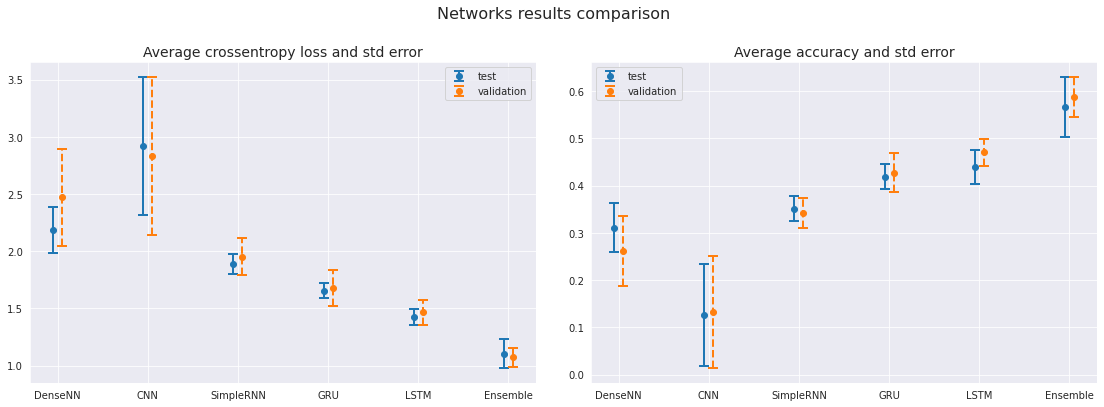

In [30]:
fig = plt.figure(figsize=(16, 6))
with sns.axes_style(style="darkgrid"):
    fig.suptitle('Networks results comparison', fontsize=16)
    gs = gridspec.GridSpec(nrows=1, ncols=2)

    ax1 = fig.add_subplot(gs[0, 0])
    x = np.arange(len(networks_results.keys()))
    test_loss = np.array([(networks_results[net]['test_loss'].mean(), networks_results[net]['test_loss'].std()) for net in networks_results.keys()])
    val_loss = np.array([(networks_results[net]['val_loss'].mean(), networks_results[net]['val_loss'].std()) for net in networks_results.keys()])

    eb1 = ax1.errorbar(x-0.05, test_loss[:,0], test_loss[:,1], linestyle='None', marker='o', capsize=5, elinewidth=2, capthick=2, label='test')
    eb2 = ax1.errorbar(x+0.05, val_loss[:,0], val_loss[:,1], linestyle='None', marker='o', capsize=5, elinewidth=2, capthick=2, label='validation')
    eb2[-1][0].set_linestyle('--')
    plt.xticks(x, networks_results.keys())
    plt.title('Average crossentropy loss and std error', fontsize=14)
    plt.legend()

    ax2 = fig.add_subplot(gs[0, 1])
    test_acc = np.array([(networks_results[net]['test_accuracy'].mean(), networks_results[net]['test_accuracy'].std()) for net in networks_results.keys()])
    val_acc = np.array([(networks_results[net]['val_accuracy'].mean(), networks_results[net]['val_accuracy'].std()) for net in networks_results.keys()])

    eb3 = ax2.errorbar(x-0.05, test_acc[:,0], test_acc[:,1], linestyle='None', marker='o', capsize=5, elinewidth=2, capthick=2, label='test')
    eb4 = ax2.errorbar(x+0.05, val_acc[:,0], val_acc[:,1], linestyle='None', marker='o', capsize=5, elinewidth=2, capthick=2, label='validation')
    eb4[-1][0].set_linestyle('--')
    plt.xticks(x, networks_results.keys())
    plt.title('Average accuracy and std error', fontsize=14)
    plt.legend()

fig.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
fig.savefig(f'{PLOTS_FOLDER}/networks_results_comparison.png')
plt.show()

### Ensemble confusion matrix

In [13]:
def display_testing_phase_results(conf_matrix, my_labels, errors_distribution, network_name='network'):
    separators = True
    annotate_matrix = False
    n_outputs = len(my_labels)
    fig = plt.figure(figsize=(14, 9))
    fig.suptitle(f'Performances of {network_name} testing', fontsize=16)
    gs = gridspec.GridSpec(nrows=3, ncols=3)

    ax1 = fig.add_subplot(gs[:, :-1])
    ax1.set_title('Confusion matrix', fontsize=14)
    conf_matrix_norm = normalize(conf_matrix, axis=1, norm='l1')
    im = ax1.imshow(conf_matrix_norm, cmap=sns.cubehelix_palette(as_cmap=True, light=.98, gamma=0.75), vmin=0, vmax=1)

    ax1.vlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    ax1.hlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    if annotate_matrix:
        rows, columns = conf_matrix.shape
        for i in range(rows):
            for j in range(columns):
                c = int(conf_matrix[i][j]) if conf_matrix[i][j].is_integer() else conf_matrix[i][j]
                if c > 0:
                    color = 'White' if conf_matrix_norm[i][j]>=.65 else 'Black'
                    ax1.text(j, i, str(round(c,0)), va='center', ha='center', c=color, fontsize=12)
    ax1.set_xticks(list(range(n_outputs)))
    ax1.set_yticks(list(range(n_outputs)))
    ax1.set_xticklabels(my_labels)
    ax1.set_yticklabels(my_labels)
    ax1.set_ylabel('true value', fontsize=12)
    ax1.set_xlabel('prediction', fontsize=12)
    if separators:
        seps = []
        past_label = my_labels[0]
        for i, l in enumerate(my_labels):
            l = str(l)
            if len(l) == 1 or l[0] != past_label:
                seps.append(i - 0.5)
            past_label = l[0]
        ax1.vlines(seps, -0.5, n_outputs - 0.5, linewidth=1, color='k')
        ax1.hlines(seps, -0.5, n_outputs - 0.5, linewidth=1, color='k')

    ax2 = fig.add_subplot(gs[0, -1])
    ax2.set_title('Distance from the diagonal', fontsize=14)
    x = list(errors_distribution.keys())
    x.sort()
    y = [errors_distribution[distance] for distance in x]
    ax2.step(x, y, where='mid', c='midnightblue')
    ax2.axvspan(-1.5, 1.5, alpha=0.4, color='palevioletred')
    x_max = min(max(list(errors_distribution.keys())), 10)
    lim = x_max if x_max%2 == 0 else x_max-1
    lim = min(lim, 10)
    ax2.set_xticks(list(range(-lim, lim+2, 2)))
    ax2.set_xlim(-x_max, x_max)
    ax2.set_yscale('log')
    ax2.set_ylabel('n errors', fontsize=12)
    ax2.set_xlabel('distance', fontsize=12, y=-10)
    
    e0 = errors_distribution[0]
    e1 = errors_distribution[1]+errors_distribution[-1]
    
    ax3 = fig.add_subplot(gs[1, -1])
    ax3.axis('off')
    ax3.text(0,0.9,f'Distance 0: {round(e0, 3)} [{round(e0/len(y_test)*100, 1)}%]', fontsize=11.5)
    ax3.text(0,0.8,f'Distance ±1: {round(e0+e1, 3)} [{round((e0+e1)/len(y_test)*100, 1)}%]', fontsize=11.5)


    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    fig.savefig(f'{PLOTS_FOLDER}/{network_name.replace(" ", "_")}_testing_results.png')
    plt.show()


In [20]:
predictions_array = []
test_accuracy = []
net_name = 'Ensemble'
for k in range(K):
    # Retrieving the network trained on x_train[K]
    network = tf.keras.models.load_model(f'../results/offline/{net_name}/best_rep_{k}.model')
    prediction = network.predict(x_test)
    test_accuracy.append(accuracy_score(y_true=y_test.argmax(axis=1), y_pred=prediction.argmax(axis=1)))
    print(f'{k+1}/{K} [{round(test_accuracy[-1], 3)}]', end='\t')
    predictions_array.append(label_encoder.inverse_transform(prediction.argmax(axis=1)))

test_accuracy = np.array(test_accuracy)
predictions_array = np.array(predictions_array)
print(f'{round(test_accuracy.mean(), 3)}')

1/5 [0.492]	2/5 [0.615]	3/5 [0.508]	4/5 [0.662]	5/5 [0.554]	0.566


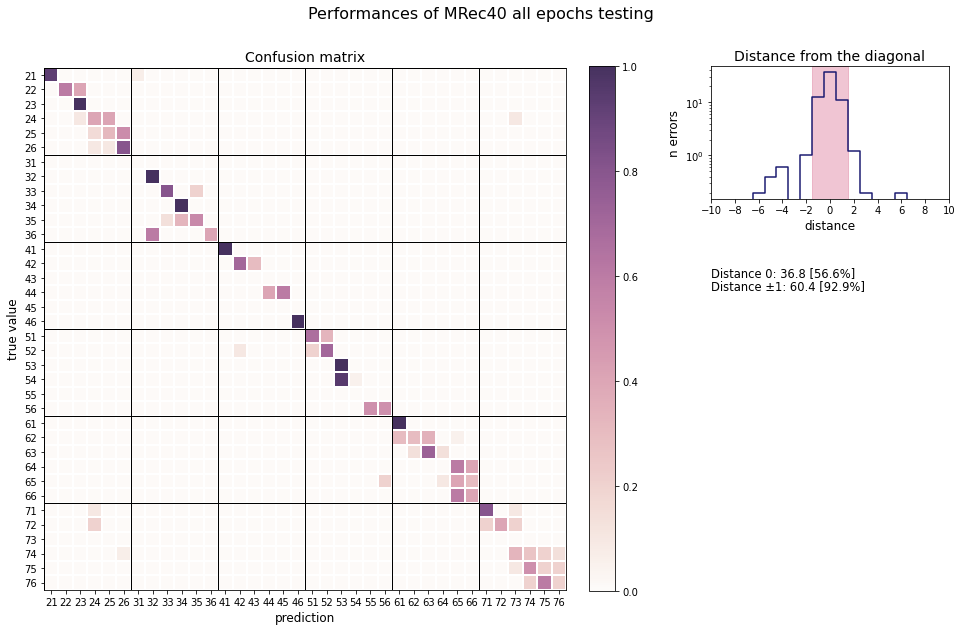

In [21]:
labels = [x for x in label_encoder.classes_]
conf_matrix, my_labels = my_confusion_matrix(predictions_array, label_encoder.inverse_transform(y_test.argmax(axis=1)), labels=labels, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

display_testing_phase_results(conf_matrix, my_labels, errors_distribution, f'{FILE} all epochs')

### Changing window

In [21]:
results = {}
networks_to_try = ['DenseNN', 'SimpleRNN', 'GRU', 'LSTM', 'CNN', 'Ensemble']

for net_name in networks_to_try:
    print(f'### {net_name} ###')
    results[net_name] = {}
    print('Window size: ', end='\t')
    
    for smaller_window in range(1, window+1):
        print(f'[{smaller_window} -- ', end='')
        p_x_test = np.array([np.pad(recording[:, :smaller_window], ((0, 0), (window-smaller_window, 0))) for recording in x_test])    
        
        test_accuracy = []
        test_loss = []
        for k in range(K):
            # Retrieving the network trained on x_train[K]
            network = tf.keras.models.load_model(f'../results/offline/{net_name}/best_rep_{k}.model')
            prediction = network.predict(p_x_test)
            test_accuracy.append(accuracy_score(y_true=y_test.argmax(axis=1), y_pred=prediction.argmax(axis=1)))
            test_loss.append(log_loss(y_test, prediction))
        
        test_accuracy = np.array(test_accuracy)
        test_loss = np.array(test_loss)
        print(f'{round(test_accuracy.mean(), 3)}]', end='\t')
        
        results[net_name][smaller_window] = {
            'test_accuracy': test_accuracy,
            'test_loss': test_loss,
        }
    print('')

pkl.dump(results, open('../results/offline/results_dict_padded.pkl', "wb"))

### DenseNN ###
Window size: 	[1 -- 0.034]	[2 -- 0.077]	[3 -- 0.065]	[4 -- 0.052]	[5 -- 0.098]	[6 -- 0.098]	[7 -- 0.117]	[8 -- 0.12]	[9 -- 0.126]	[10 -- 0.129]	[11 -- 0.135]	[12 -- 0.151]	[13 -- 0.222]	[14 -- 0.252]	[15 -- 0.311]	
### SimpleRNN ###
Window size: 	[1 -- 0.049]	[2 -- 0.046]	[3 -- 0.043]	[4 -- 0.052]	[5 -- 0.065]	[6 -- 0.071]	[7 -- 0.065]	[8 -- 0.037]	[9 -- 0.071]	[10 -- 0.074]	[11 -- 0.105]	[12 -- 0.151]	[13 -- 0.212]	[14 -- 0.28]	[15 -- 0.351]	
### GRU ###
Window size: 	[1 -- 0.071]	[2 -- 0.037]	[3 -- 0.034]	[4 -- 0.095]	[5 -- 0.077]	[6 -- 0.089]	[7 -- 0.086]	[8 -- 0.089]	[9 -- 0.129]	[10 -- 0.151]	[11 -- 0.135]	[12 -- 0.28]	[13 -- 0.295]	[14 -- 0.277]	[15 -- 0.418]	
### LSTM ###
Window size: 	[1 -- 0.055]	[2 -- 0.043]	[3 -- 0.034]	[4 -- 0.04]	[5 -- 0.052]	[6 -- 0.062]	[7 -- 0.089]	[8 -- 0.117]	[9 -- 0.132]	[10 -- 0.203]	[11 -- 0.218]	[12 -- 0.292]	[13 -- 0.338]	[14 -- 0.363]	[15 -- 0.44]	
### CNN ###
Window size: 	[1 -- 0.018]	[2 -- 0.018]	[3 -- 0.015]	[4 -- 0.012]	[5 -

In [19]:
p_networks_results = pkl.load(open('../results/offline/results_dict_padded.pkl', "rb"))

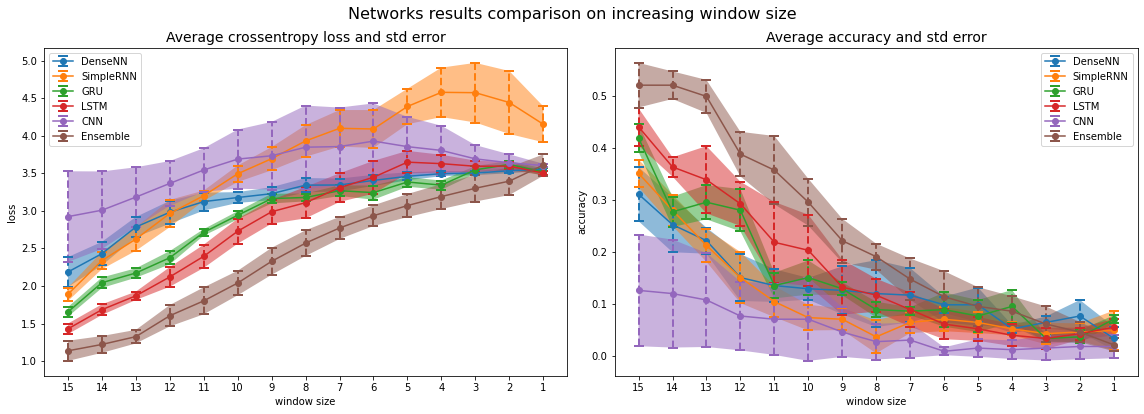

In [20]:
smaller_windows = p_networks_results[list(p_networks_results.keys())[0]].keys()
x = np.flip(np.arange(len(smaller_windows)))

fig = plt.figure(figsize=(16, 6))
fig.suptitle('Networks results comparison on increasing window size', fontsize=16)
gs = gridspec.GridSpec(nrows=1, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Average crossentropy loss and std error', fontsize=14)
ax1.set_xlabel('window size')
ax1.set_ylabel('loss')
ax1.set_xticks(x)
ax1.set_xticklabels(smaller_windows)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Average accuracy and std error', fontsize=14)
ax2.set_xlabel('window size')
ax2.set_ylabel('accuracy')
ax2.set_xticks(x)
ax2.set_xticklabels(smaller_windows)

for i, net in enumerate(p_networks_results.keys()):
    
    test_loss = np.array([(p_networks_results[net][sw]['test_loss'].mean(), p_networks_results[net][sw]['test_loss'].std()) for sw in smaller_windows])
    fb1 = ax1.fill_between(x, test_loss[:,0]-test_loss[:,1], test_loss[:,0]+test_loss[:,1], alpha=.5)
    eb1 = ax1.errorbar(x, test_loss[:,0], test_loss[:,1], linestyle='-', marker='o', capsize=5, elinewidth=2, capthick=2, label=f'{net}')
    eb1[-1][0].set_linestyle('--')
    
    test_acc = np.array([(p_networks_results[net][sw]['test_accuracy'].mean(), p_networks_results[net][sw]['test_accuracy'].std()) for sw in smaller_windows])
    fb2 = ax2.fill_between(x, test_acc[:,0]-test_acc[:,1], test_acc[:,0]+test_acc[:,1], alpha=.5)
    eb2 = ax2.errorbar(x, test_acc[:,0], test_acc[:,1], linestyle='-', marker='o', capsize=5, elinewidth=2, capthick=2, label=f'{net}')
    eb2[-1][0].set_linestyle('--')

ax1.legend()
ax2.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(f'{PLOTS_FOLDER}/all_network_changing_window.png')
plt.show()